In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, matthews_corrcoef, roc_curve, roc_auc_score, auc, precision_recall_curve

In [2]:
# Read the stroke_diagnosis.csv file
df = pd.read_csv("CSV\imports\o05_30_percent_filled_dataset.csv")

In [3]:
# Reorder hospital_expire_flag column
column_order = list(df.columns)
column_order.remove('hospital_expire_flag')  # Remove 'flag' from the original position
column_order.append('hospital_expire_flag')  # Add 'flag' to the end

# Reindex the DataFrame
df = df.reindex(columns=column_order)

# Filter icu stay less than 10 days
df = df[df['los'] < 10]

# Filter Time Zone
#df = df[df['Time_Zone'] == 1]

In [4]:
display (df)

,row_count,subject_id,hadm_id,Time_Zone,gender,age,language,marital_status,race,Base Excess,...,CK-MB,Glucose.2,Potassium Whole Blood,Glucose (whole blood),Potassium (whole blood),Creatine Kinase MB Isoenzyme,los,GCS,Braden,hospital_expire_flag
0,1,10004733,27411876,1,M,51,ENGLISH,SINGLE,UNKNOWN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.357373,8.000000,11.0,0
1,2,10004733,27411876,2,M,51,ENGLISH,SINGLE,UNKNOWN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.357373,8.500000,11.0,0
2,3,10004733,27411876,3,M,51,ENGLISH,SINGLE,UNKNOWN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.357373,8.000000,11.0,0
3,4,10004733,27411876,4,M,51,ENGLISH,SINGLE,UNKNOWN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.357373,8.333333,11.0,0
4,5,10004733,27411876,5,M,51,ENGLISH,SINGLE,UNKNOWN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.357373,8.333333,11.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55787,55788,19999987,23865745,12,F,57,ENGLISH,NaN,UNKNOWN,1.0,...,43.0,NaN,NaN,NaN,NaN,43.0,1.937847,8.250000,12.8,0
55788,55789,19999987,23865745,13,F,57,ENGLISH,NaN,UNKNOWN,1.0,...,45.5,NaN,NaN,NaN,NaN,45.5,1.937847,8.111111,12.5,0
55789,55790,19999987,23865745,14,F,57,ENGLISH,NaN,UNKNOWN,1.0,...,43.0,NaN,NaN,NaN,NaN,43.0,1.937847,8.250000,12.8,0
55790,55791,19999987,23865745,15,F,57,ENGLISH,NaN,UNKNOWN,1.0,...,44.0,NaN,NaN,NaN,NaN,44.0,1.937847,7.000000,13.0,0


In [5]:
# Set training percentage. The difference goes to test set
training_percentage = 0.7

# It's already sorted. Just for precaution. Sort by 'subject_id' and 'Time_Zone')
df = df.sort_values(by=['subject_id', 'Time_Zone'])

# Calculate the total number of unique subject IDs
unique_subject_ids = df['subject_id'].nunique()

# Calculate the number of unique subject IDs to include in the training set
train_subject_ids_count = int(training_percentage * unique_subject_ids)

# Initialize variables to track the number of subject IDs included in the training set
subject_ids_in_training = 0

# Initialize empty DataFrames for the training and test sets
train_df = pd.DataFrame(columns=df.columns)
test_df = pd.DataFrame(columns=df.columns)

# Iterate through the sorted DataFrame
for subject_id, subject_data in df.groupby('subject_id'):
    if subject_ids_in_training < train_subject_ids_count:
        # Add this subject's data to the training set
        train_df = pd.concat([train_df, subject_data])
        subject_ids_in_training += 1
    else:
        # Add this subject's data to the test set
        test_df = pd.concat([test_df, subject_data])

# Reset the index of the resulting DataFrames
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

C:\Users\dimop\AppData\Local\Temp\ipykernel_21076\2078206995.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([train_df, subject_data])
C:\Users\dimop\AppData\Local\Temp\ipykernel_21076\2078206995.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_df = pd.concat([test_df, subject_data])


In [6]:
# Concatenate train_df and test_df for consistent encoding of categorical variables
combined_df = pd.concat([train_df, test_df], axis=0)

# Encode categorical variables
categorical_cols = ['gender', 'language', 'marital_status', 'race']
combined_df_encoded = pd.get_dummies(combined_df, columns=categorical_cols)

# Convert 'age' column to numeric type
combined_df_encoded['age'] = pd.to_numeric(combined_df_encoded['age'], errors='coerce')

# Convert 'hospital_expire_flag' column to boolean type
combined_df_encoded['hospital_expire_flag'] = combined_df_encoded['hospital_expire_flag'].astype(bool)


# Split the dataframe at the original row index (before concatenation)
combined_df_encoded_train = combined_df_encoded.iloc[:len(train_df)]
combined_df_encoded_test = combined_df_encoded.iloc[len(train_df):]

# Split data into features and target variable again
X_train = combined_df_encoded_train.drop(['row_count', 'subject_id', 'hadm_id', 'Time_Zone', 'hospital_expire_flag'], axis=1)
y_train = combined_df_encoded_train['hospital_expire_flag']
X_test = combined_df_encoded_test.drop(['row_count', 'subject_id', 'hadm_id', 'Time_Zone', 'hospital_expire_flag'], axis=1)
y_test = combined_df_encoded_test['hospital_expire_flag']


# Define XGBoost model
model = xgb.XGBClassifier()

# Train the model
model.fit(X_train, y_train)

# Predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
kappa = cohen_kappa_score(y_test, predictions)
mcc = matthews_corrcoef(y_test, predictions)
print("Accuracy:", accuracy)
print("\nCohen's Kappa:", kappa)
print("\nMatthews Correlation Coefficient (MCC):", mcc)

# Additional evaluation metrics
print("\n",classification_report(y_test, predictions))

Accuracy: 0.9023394994559304

Cohen's Kappa: 0.6564779307106259

Matthews Correlation Coefficient (MCC): 0.6692250064924282

               precision    recall  f1-score   support

       False       0.91      0.97      0.94     11792
        True       0.85      0.61      0.71      2912

    accuracy                           0.90     14704
   macro avg       0.88      0.79      0.83     14704
weighted avg       0.90      0.90      0.90     14704



# Most important features

In [7]:
# Get feature importances
feature_importance = model.feature_importances_

# Create a DataFrame to store feature importances along with their corresponding names
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by feature importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top N most important features
top_n = 20  # set features number
print(f"Top {top_n} most important features:")
print(feature_importance_df.head(top_n))

Top 20 most important features:
                                 Feature  Importance
221                                  GCS    0.087581
83                       Ventilator Mode    0.058530
80                       O2 Flow (L/min)    0.042442
222                               Braden    0.035839
208         Arterial Line Zero/Calibrate    0.028596
102  Respiratory Rate (Total) (insp/min)    0.019464
13                           Bicarbonate    0.017010
175                 Orientation to Place    0.015232
54           Arterial O2 pressure (mmHg)    0.014681
66                    Creatinine (serum)    0.012520
60                      PEEP set (cmH2O)    0.012327
11                             Anion Gap    0.012194
10                  Alkaline Phosphatase    0.012107
109            Any fear in relationships    0.011856
93                        Spont RR (bpm)    0.011382
229                marital_status_SINGLE    0.010016
217                Glucose (whole blood)    0.009935
230           

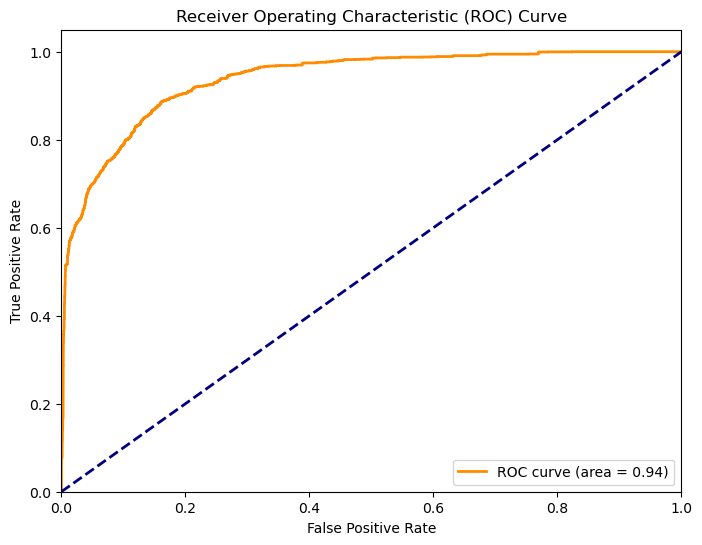

In [8]:
# Get predicted probabilities for the positive class
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


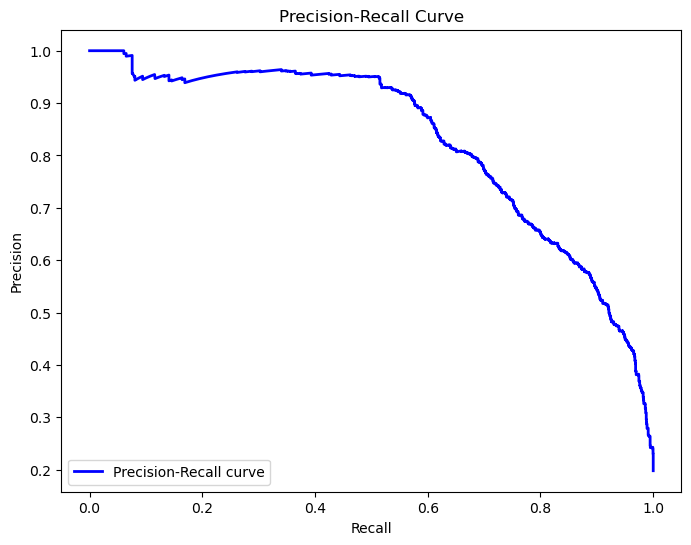

In [9]:
# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Testing Field

In [10]:
# Extract subject_id, hadm_id, and Time_Zone from the test data
predictions_df = test_df[['subject_id', 'hadm_id', 'Time_Zone']].copy()

# Create the ID column by concatenating the values of 'subject_id', 'hadm_id'
predictions_df['subject_&_hadm'] = predictions_df['subject_id'].astype(str) + predictions_df['hadm_id'].astype(str)

# Add predictions column
predictions_df['prediction'] = predictions

# Combine predictions DataFrame with true values DataFrame
predictions_df = pd.concat([predictions_df, pd.DataFrame({'Ground Truth': y_test.values})], axis=1)

# Create a new column 'Prediction_of_alive' and set its value to 1 if 'prediction' is 0, otherwise 0
predictions_df['Prediction_of_alive'] = predictions_df['prediction'].apply(lambda x: 1 if x == 0 else 0)

# Create a new column 'Prediction_of_alive' and set its value to 1 if 'prediction' is 0, otherwise 0
predictions_df['Prediction_of_death'] = predictions_df['prediction'].apply(lambda x: 1 if x == 1 else 0)

# Replace 'False' with 0 and 'True' with 1 in the 'Ground Truth' column
predictions_df['Ground Truth'] = predictions_df['Ground Truth'].replace({False: 0, True: 1})

In [11]:
"""
Calculate the probability of Alive and Death
"""

# Create a new column 'denominator' that counts for each 'subject_&_hadm'
predictions_df['Denominator'] = predictions_df.groupby('subject_&_hadm').cumcount() + 1


# Create the 'Numerator' column
predictions_df['Numerator'] = predictions_df.groupby('subject_&_hadm')['Prediction_of_alive'].transform(
    lambda x: x.cumsum()
)

# Fill NaN values with 0
predictions_df['Numerator'] = predictions_df['Numerator'].fillna(0)

# Probability of Alive
predictions_df['Probability_of_Alive'] = predictions_df['Numerator'] / predictions_df['Denominator']

# Probability of Death
predictions_df['Probability_of_Death'] = 1 - predictions_df['Probability_of_Alive']


# Repositioning the columns in the DataFrame
columns_to_move = ['subject_&_hadm', 'subject_id', 'hadm_id', 'Time_Zone',
                   'Prediction_of_alive', 'Prediction_of_death',
                   'Ground Truth', 'Numerator','Denominator',
                   'Probability_of_Alive', 'Probability_of_Death']
predictions_df = predictions_df[columns_to_move + [col for col in predictions_df.columns if col not in columns_to_move]]


# Export to csv
#predictions_df.to_csv(export_file_path, index=False)

In [12]:
# Variables
algorithm_label = 'Mimic IV - XGBoost'
xlabel = 'False Positive Rate'
ylabel = 'True Positive Rate'

"""
Assign to variables the values of the first
3, 6, 12 and 24 hour
No1 = first 3 hours
No2 = first 6 hours
...
No16 = first 48 hours
"""
hour1 = predictions_df.loc[predictions_df['Denominator'] == 1] # first 3 hours
hour2 = predictions_df.loc[predictions_df['Denominator'] == 2] # first 6 hours
hour3 = predictions_df.loc[predictions_df['Denominator'] == 4] # first 12 hours
hour4 = predictions_df.loc[predictions_df['Denominator'] == 8] #first 24 hours

"""
Assign to variables values for every hour from
the column Ground Truth Alive and convert from
dataframe to list.
"""

ground_truth_alive1 = hour1["Ground Truth"].tolist()
ground_truth_alive2 = hour2["Ground Truth"].tolist()
ground_truth_alive3 = hour3["Ground Truth"].tolist()
ground_truth_alive4 = hour4["Ground Truth"].tolist()

"""
Assign to variables values for every hour from
the column Prob - Alive and convert from
dataframe to list.
"""

prob_alive1 = hour1["Probability_of_Alive"].tolist()
prob_alive2 = hour2["Probability_of_Alive"].tolist()
prob_alive3 = hour3["Probability_of_Alive"].tolist()
prob_alive4 = hour4["Probability_of_Alive"].tolist()

"""
Assign to variables values for every hour from
the column Prob - Dead and convert from
dataframe to list.
"""

prob_dead1 = hour1["Probability_of_Death"].tolist()
prob_dead2 = hour2["Probability_of_Death"].tolist()
prob_dead3 = hour3["Probability_of_Death"].tolist()
prob_dead4 = hour4["Probability_of_Death"].tolist()

"""
To create the Ground Truth Dead per day, I subtract from
the ground_truth_alive of each hour the 1. After the subtraction
I use the abs in order to get the absolute value of it.
So I have the prices without a hitch.
With this process the values of Ground Truth Alive and Ground
Truth Dead are reversed
"""
# Ground Truth Dead per hour
# 1st hour (first 3hours)
ground_truth_dead1=abs(np.subtract(ground_truth_alive1, 1))

# 2nd hour (first 6hours)
ground_truth_dead2=abs(np.subtract(ground_truth_alive2, 1))

# 3rd hour (first 12hours)
ground_truth_dead3=abs(np.subtract(ground_truth_alive3, 1))

# 4th hour (first 24hours)
ground_truth_dead4=abs(np.subtract(ground_truth_alive4, 1))

In [13]:
"""First 3 hours"""

# Your existing code for ROC curve
print("AUC = ", roc_auc_score(ground_truth_alive1, prob_alive1))
fpr1, tpr1, thresholds1 = roc_curve(ground_truth_alive1, prob_alive1)
pyplot.plot(fpr1, tpr1, linestyle='--', label='First 3 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds1):
    pyplot.scatter(fpr1[i], tpr1[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label + " (Alive)")

print("Thresholds          ", thresholds1)
print("False Possitive Rate", fpr1)
print("True Possitive Rate", tpr1)

# Save the plot in high resolution (adjust the dpi as needed)
#plt.savefig('plots/alive_roc_3hour_plot.png', dpi=300)

# Show the plot
pyplot.show()

AUC =  0.19834642968971328


NameError: name 'pyplot' is not defined

In [ ]:
"""First 6 hours"""

print("AUC = ", roc_auc_score(ground_truth_alive2, prob_alive2))
fpr2, tpr2, thresholds2 = roc_curve(ground_truth_alive2, prob_alive2)
pyplot.plot(fpr2, tpr2, linestyle='--', label='First 6 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds2):
    pyplot.scatter(fpr2[i], tpr2[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label + " (Alive)")

print("Thresholds          ", thresholds2)
print("False Possitive Rate", fpr2)
print("True Possitive Rate", tpr2)

# Save the plot in high resolution (adjust the dpi as needed)
#plt.savefig('plots/alive_roc_6hour_plot.png', dpi=300)


# Show the plot
pyplot.show()

In [ ]:
# Your existing code for ROC curve
print("AUC = ", roc_auc_score(ground_truth_dead1, prob_dead1))
fpr1, tpr1, thresholds1 = roc_curve(ground_truth_dead1, prob_dead1)
pyplot.plot(fpr1, tpr1, linestyle='--', label='First 3 Hours')

# Scatter plot for thresholds
for i, threshold in enumerate(thresholds1):
    pyplot.scatter(fpr1[i], tpr1[i], marker='o', color='black', label=f'Threshold = {threshold:.2f}')

pyplot.xlabel(xlabel)
pyplot.ylabel(ylabel)
pyplot.legend()
pyplot.grid(True)
pyplot.title(algorithm_label + " (Dead)")

print("Thresholds          ", thresholds1)
print("False Possitive Rate", fpr1)
print("True Possitive Rate", tpr1)

# Show the plot
pyplot.show()